In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bowlers = pd.read_csv('/content/drive/My Drive/bowler_level_scorecard.csv')
batsmen = pd.read_csv('/content/drive/My Drive/batsman_level_scorecard.csv')
matches = pd.read_csv('/content/drive/My Drive/match_level_scorecard.csv')
train_data = pd.read_csv('/content/drive/My Drive/train_data.csv')
test_data = pd.read_csv('/content/drive/My Drive/test_data.csv')

In [ ]:
train_data['winner_01'] = train_data.apply(lambda x: 1 if (x['team2']==x['winner']) else 0, axis=1)

In [ ]:
train_data['toss_winner_01'] = np.where(train_data['toss winner']==train_data['team2'], 1, 0)
test_data['toss_winner_01'] = np.where(test_data['toss winner']==test_data['team2'], 1, 0)

In [ ]:
train_data['toss_decision_01'] = np.where(train_data['toss decision']=='bat', 1, 0)
test_data['toss_decision_01'] = np.where(test_data['toss decision']=='bat', 1, 0)

In [ ]:
batters = set()
averages = {}
cnt = {}
total_balls_faced = {}
strike_rates = {}

for i in range(len(batsmen)):
    batsman_id = batsmen['batsman_id'][i]

    if batsman_id not in averages:
        averages[batsman_id] = 0
    if batsman_id not in cnt:
        cnt[batsman_id] = 0
    if batsman_id not in total_balls_faced:
        total_balls_faced[batsman_id] = 0

    batters.add(batsman_id)

    if batsmen['wicket kind'][i] != 'not out':
        cnt[batsman_id] += 1

    averages[batsman_id] += batsmen['runs'][i]
    total_balls_faced[batsman_id] += batsmen['balls_faced'][i]

for batter in batters:
    if total_balls_faced[batter] > 0:
        strike_rates[batter] = (averages[batter] / total_balls_faced[batter]) * 100
    else:
        strike_rates[batter] = 0

    if cnt[batter] > 0:
        averages[batter] = averages[batter] / cnt[batter]
    else:
        averages[batter] = float('nan')

In [ ]:
averages

{7907451.0: 24.7,
 4381761.0: 22.661538461538463,
 4949790.0: 13.266666666666667,
 3834305.0: 12.583333333333334,
 3776849.0: 12.11111111111111,
 6718340.0: 6.5,
 31464.0: 3.3333333333333335,
 258649.0: 23.0,
 2653993.0: 34.507462686567166,
 6718326.0: 27.4625,
 6718382.0: 13.045454545454545,
 37351.0: 25.64516129032258,
 46794.0: 32.36842105263158,
 1594319.0: 16.16949152542373,
 7534687.0: 22.65,
 7537067.0: 7.904761904761905,
 5406540.0: 18.193548387096776,
 2231928.0: 23.9873417721519,
 181404.0: 15.530303030303031,
 1506098.0: 28.346153846153847,
 1749075.0: 28.13888888888889,
 36665.0: 20.8,
 2083409.0: 20.681818181818183,
 7869987.0: 24.58490566037736,
 7620283.0: 21.0,
 3063696.0: 22.96551724137931,
 34061.0: 12.555555555555555,
 3200756.0: 11.942307692307692,
 4756982.0: 10.052631578947368,
 7455818.0: 4.142857142857143,
 49496.0: 4.0,
 2076192.0: 32.2020202020202,
 4002340.0: 20.115384615384617,
 7620269.0: 22.333333333333332,
 2535420.0: 12.380952380952381,
 4967738.0: 9.217

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Strike Rate vs Average')

Text(0.5, 0, 'Strike Rate')

Text(0, 0.5, 'Average')

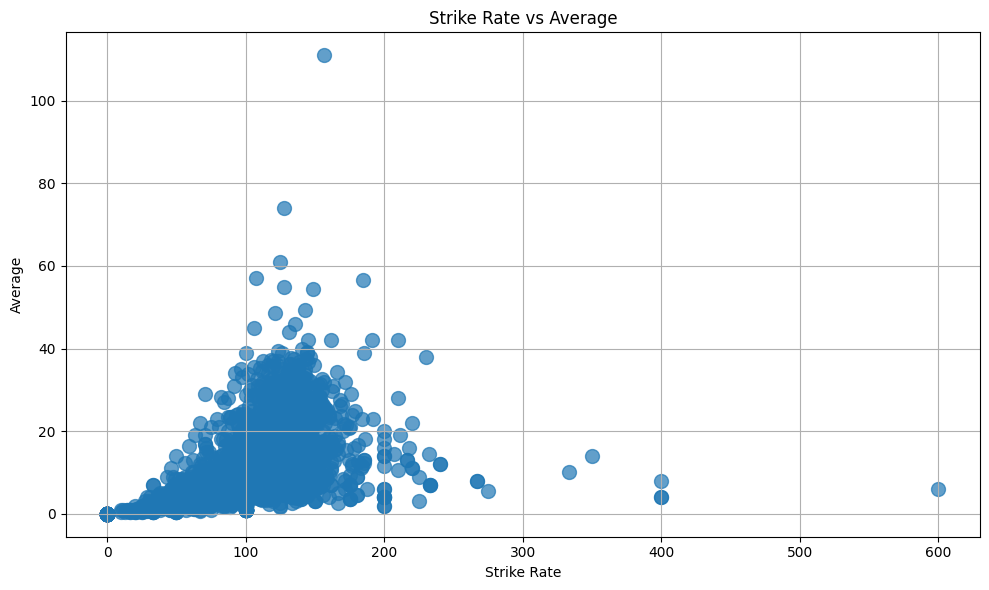

In [ ]:
batters = list(batters)

data = pd.DataFrame({
    'Average': [averages[b] for b in batters],
    'Strike Rate': [strike_rates[b] for b in batters],
    'batsman_id': batters
})

data.dropna(inplace=True)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['Strike Rate'], data['Average'], s=100, alpha=0.7)

plt.title('Strike Rate vs Average')
plt.xlabel('Strike Rate')
plt.ylabel('Average')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Assuming 'data' is a DataFrame with 'Average', 'Strike Rate', and 'batsman_id' columns

mean_average = np.mean(data['Average'])
mean_strike_rate = np.mean(data['Strike Rate'])
std_average = np.std(data['Average'])
std_strike_rate = np.std(data['Strike Rate'])

average_z_scores = (data['Average'] - mean_average) / std_average
strike_rate_z_scores = (data['Strike Rate'] - mean_strike_rate) / std_strike_rate

combined_batting_z_scores = average_z_scores + strike_rate_z_scores

batting_results = pd.DataFrame({
    'batsman_id': data['batsman_id'],
    'combined_z_score': combined_batting_z_scores,
    'average_z_score': average_z_scores,
    'strike_rate_z_score': strike_rate_z_scores
})

bat_pow = {batting_results['batsman_id'][i]: batting_results['combined_z_score'][i] for i in range(len(batting_results))}


In [ ]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data[['Strike Rate', 'Average']])
# scaled_df = pd.DataFrame(scaled_data, columns=['Scaled Strike Rate', 'Scaled Average'])
# covariance_sr_avg = scaled_df['Scaled Strike Rate'].cov(scaled_df['Scaled Average'])
# covariance_avg_sr = scaled_df['Scaled Average'].cov(scaled_df['Scaled Strike Rate'])
# print(f"Covariance between Scaled Strike Rate and Scaled Average: {covariance_sr_avg}")
# print(f"Covariance between Scaled Average and Scaled Strike Rate: {covariance_avg_sr}")

In [ ]:
# total_covariance = covariance_sr_avg + covariance_avg_sr
# weight_sr = covariance_sr_avg / total_covariance
# weight_avg = covariance_avg_sr / total_covariance

# data['sr_score'] = scaled_df['Scaled Strike Rate']*weight_sr+weight_avg*scaled_df['Scaled Average']

In [ ]:
# bat_pow = data.set_index('batsman_id')['sr_score'].to_dict()
# print(bat_pow)

In [ ]:
bowler = set()
economy = {}
wickets_taken = {}
count = {}

for i in range(len(bowlers)):
    bowler_id = bowlers['bowler_id'][i]

    if bowler_id not in economy:
        economy[bowler_id] = 0
    if bowler_id not in wickets_taken:
        wickets_taken[bowler_id] = 0
    if bowler_id not in count:
        count[bowler_id] = 0

    bowler.add(bowler_id)

    count[bowler_id] += 1

    wickets_taken[bowler_id] += bowlers['wicket_count'][i]
    economy[bowler_id] += bowlers['economy'][i]


economy_values = []
wickets_taken_values = []

for Bowler in bowler:
    economy_values.append(economy[Bowler]/count[Bowler])
    wickets_taken_values.append(wickets_taken[Bowler])
#    wickets_taken_values.append(wickets_taken[Bowler]/count[Bowler])

In [ ]:
  mean_economy = np.mean(economy_values)
  mean_wickets_taken = np.mean(wickets_taken_values)
  std_economy = np.std(economy_values)
  std_wickets_taken = np.std(wickets_taken_values)

  economy_z_scores = (economy_values - mean_economy) / std_economy
  wickets_z_scores = (wickets_taken_values - mean_wickets_taken) / std_wickets_taken

  adjusted_economy_z_scores = -economy_z_scores

  combined_z_scores = adjusted_economy_z_scores + wickets_z_scores

  results = pd.DataFrame({
      'bowler_id': list(bowler),
#      'combined_z_score': combined_z_scores
      'economy_z_score' : economy_z_scores,
      'wickets_z_score' : wickets_z_scores
  })

  bow_pow1 = {}
  bow_pow2 = {}
  for i in range(len(results)):
    bow_pow1[results['bowler_id'][i]] = results['wickets_z_score'][i]
    bow_pow2[results['bowler_id'][i]] = results['economy_z_score'][i]
  # print(bow_pow)

  # results.head()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'economy vs wicket count')

Text(0.5, 0, 'avg economy')

Text(0, 0.5, 'wicket count')

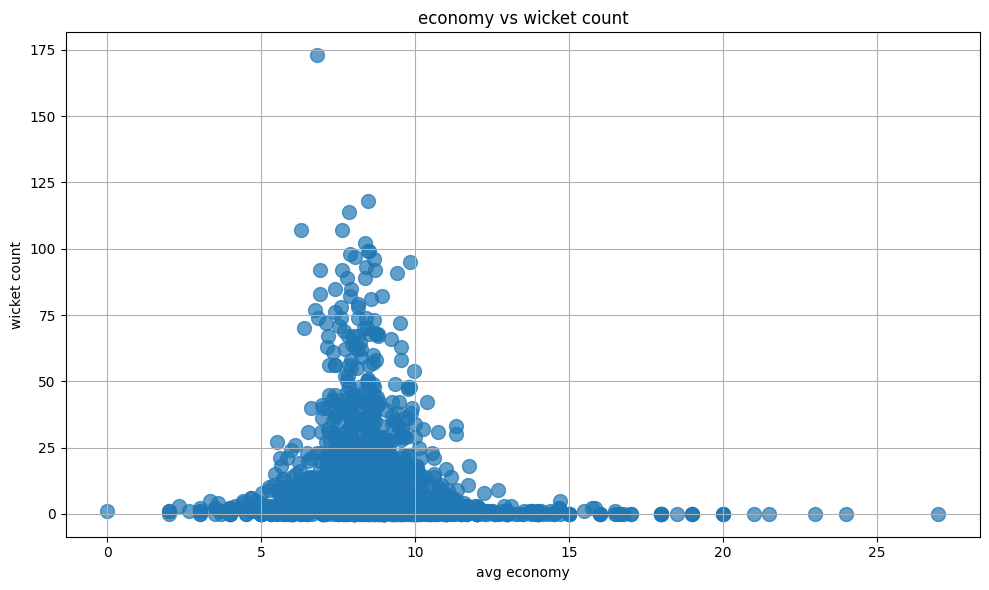

In [ ]:
bowling = list(bowler)

df = pd.DataFrame({
    'economy': [economy[b]/count[b] for b in bowling],
    'wicket count': [wickets_taken[b] for b in bowling],
    'bowler_id': bowling
})

df.dropna(inplace=True)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['economy'], df['wicket count'], s=100, alpha=0.7)

plt.title('economy vs wicket count')
plt.xlabel('avg economy')
plt.ylabel('wicket count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
train_data['light'] = 0
test_data['light'] = 0

for i in range(len(train_data)):
  #lighting
  if(train_data['lighting'][i] == 'day'):
    train_data['light'][i] = 1
  elif(train_data['lighting'][i] == 'night'):
    train_data['light'][i] = 2
  else:
    train_data['light'][i] = 3

for i in range(len(test_data)):
  if(test_data['lighting'][i] == 'day'):
    test_data['light'][i] = 1
  elif(test_data['lighting'][i] == 'night'):
    test_data['light'][i] = 2
  else:
    test_data['light'][i] = 3

In [ ]:
train_data.columns
test_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'toss_winner_01',
       'toss_decision_01', 'light'],
      dtype='object')

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'toss winner', 'toss decision', 'venue',
       'city', 'match_dt', 'lighting', 'series_name', 'season', 'ground_id',
       'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'toss_winner_01', 'toss_decision_01',
       'light'],
      dtype='object')

In [ ]:
def add_features(train_data, bat_pow, bow_pow1,bow_pow2):
    train_data['net sr score'] = 0
#    train_data['net bow score'] = 0
    train_data['net wickets score']=0
    train_data['net economy score']=0
    for i in range(len(train_data)):
        sr_t1 = 0
        w_t1 = 0
        e_t1=0
        sr_t2 = 0
        w_t2 = 0
        e_t2=0

        s = train_data['team1_roster_ids'][i].split(':')
        for mems in s:
            mems_float = np.float64(mems)
            if mems_float in bat_pow:
                sr_t1 += bat_pow[mems_float]


            if mems_float in bow_pow1:
                w_t1 += bow_pow1[mems_float]
                e_t1+=bow_pow2[mems_float]
        s1 = train_data['team2_roster_ids'][i].split(':')
        for mems in s1:
            mems_float = np.float64(mems)
            if mems_float in bat_pow:
                sr_t2 += bat_pow[mems_float]

            if mems_float in bow_pow1:
                w_t2 += bow_pow1[mems_float]
                e_t2+=bow_pow2[mems_float]

        train_data['net sr score'][i] = sr_t1 - sr_t2
        train_data['net wickets score'][i] = w_t1-w_t2
        train_data['net economy score'][i] = e_t1-e_t2
        # print(train_data['net sr score'][i])

    return train_data

In [ ]:
"""
def add_features(train_data, bat_pow, bow_pow):
    train_data['net sr score'] = 0
    train_data['net bow score'] = 0

    for i in range(len(train_data)):
        sr_t1 = []
        b_t1 = []
        sr_t2 = []
        b_t2 = []

        team1_roster = train_data['team1_roster_ids'][i].split(':')
        for mems in team1_roster:
            mems_float = np.float64(mems)
            if mems_float in bat_pow:
                sr_t1.append(bat_pow[mems_float])
            if mems_float in bow_pow:
                b_t1.append(bow_pow[mems_float])

        team2_roster = train_data['team2_roster_ids'][i].split(':')
        for mems in team2_roster:
            mems_float = np.float64(mems)
            if mems_float in bat_pow:
                sr_t2.append(bat_pow[mems_float])
            if mems_float in bow_pow:
                b_t2.append(bow_pow[mems_float])

        # Sum the top 5 scores only
        sr_t1_sum = sum(sorted(sr_t1, reverse=True)[:5])
        b_t1_sum = sum(sorted(b_t1, reverse=True)[:5])
        sr_t2_sum = sum(sorted(sr_t2, reverse=True)[:5])
        b_t2_sum = sum(sorted(b_t2, reverse=True)[:5])

        train_data.at[i, 'net sr score'] = sr_t1_sum - sr_t2_sum
        train_data.at[i, 'net bow score'] = b_t1_sum - b_t2_sum

    return train_data
"""

"\ndef add_features(train_data, bat_pow, bow_pow):\n    train_data['net sr score'] = 0\n    train_data['net bow score'] = 0\n\n    for i in range(len(train_data)):\n        sr_t1 = []\n        b_t1 = []\n        sr_t2 = []\n        b_t2 = []\n\n        team1_roster = train_data['team1_roster_ids'][i].split(':')\n        for mems in team1_roster:\n            mems_float = np.float64(mems)\n            if mems_float in bat_pow:\n                sr_t1.append(bat_pow[mems_float])\n            if mems_float in bow_pow:\n                b_t1.append(bow_pow[mems_float])\n\n        team2_roster = train_data['team2_roster_ids'][i].split(':')\n        for mems in team2_roster:\n            mems_float = np.float64(mems)\n            if mems_float in bat_pow:\n                sr_t2.append(bat_pow[mems_float])\n            if mems_float in bow_pow:\n                b_t2.append(bow_pow[mems_float])\n\n        # Sum the top 5 scores only\n        sr_t1_sum = sum(sorted(sr_t1, reverse=True)[:5])\n    

In [ ]:
train_data = add_features(train_data, bat_pow, bow_pow1,bow_pow2)
test_data = add_features(test_data, bat_pow, bow_pow1,bow_pow2)

In [ ]:
X,y = train_data[['toss_winner_01','toss_decision_01','team_count_50runs_last15','team_winp_last5','team1only_avg_runs_last15','team1_winp_team2_last15','ground_avg_runs_last15','net sr score', 'net wickets score','net economy score','playerwinratio']], train_data['winner_01']

In [ ]:
X_test = test_data[X.columns.tolist()]

In [ ]:
X_nans = X.isna().sum().reset_index()
X_nans[X_nans[0]!=0]

X_test_nans = X_test.isna().sum().reset_index()
X_test_nans[X_test_nans[0]!=0]

,index,0
4,team1only_avg_runs_last15,21
6,ground_avg_runs_last15,53


,index,0
4,team1only_avg_runs_last15,7
6,ground_avg_runs_last15,10


In [ ]:
X.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [ ]:
X_nans = X.isna().sum().reset_index()
X_nans[X_nans[0]!=0]

X_test_nans = X_test.isna().sum().reset_index()
X_test_nans[X_test_nans[0]!=0]

,index,0


,index,0


In [ ]:
X['toss_winner_01'].value_counts()
X['toss_decision_01'].value_counts()
X['team_count_50runs_last15'].describe()

toss_winner_01
1    620
0    328
Name: count, dtype: int64

toss_decision_01
0    617
1    331
Name: count, dtype: int64

count    948.000000
mean       1.202602
std        1.008793
min        0.083333
25%        0.686678
50%        1.000000
75%        1.400000
max       11.000000
Name: team_count_50runs_last15, dtype: float64

In [ ]:
  m=float('inf')
  X['playerwinratio'].replace(m,-100,inplace=True)
  X_test['playerwinratio'].replace(m,-100,inplace=True)
  X['playerwinratio'].replace(-100,X['playerwinratio'].max(),inplace=True)
  X_test['playerwinratio'].replace(-100,X_test['playerwinratio'].max(),inplace=True)

In [ ]:
X['playerwinratio'].describe()

count    948.000000
mean       1.550031
std        2.920840
min        0.000000
25%        0.863149
50%        1.072607
75%        1.411502
max       27.713570
Name: playerwinratio, dtype: float64

In [ ]:
train_data

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,toss_winner_01,toss_decision_01,light,net sr score,net wickets score,net economy score,playerwinratio,y_pred_01,win_pred_score,win_pred_team_id
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,1,0,3,0.992037,-0.107148,-2.001481,1.000000,0,0.519691,11283
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,1,0,3,-0.608286,3.615171,-1.273697,1.101339,0,0.526644,20
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,1,0,3,-2.748901,-2.179017,-1.324999,0.802433,1,0.520688,8987
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,0,1,3,3.449620,-4.677823,-0.228876,1.443254,0,0.504680,36084
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,1,0,3,3.007688,-1.116641,-0.241715,1.102033,1,0.500343,48341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044...,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000....,Pb Ks,30407,Ci Sr Ks,...,1,0,3,-0.362088,-2.391934,0.479769,0.994531,1,0.542564,30414
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:767287...,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:632036...,St,9701,St,...,1,0,3,-1.720819,-10.631768,3.916675,0.270166,1,0.554423,9701
945,9097227,Bd,22497,4239773.0:1941743.0:3007969.0:4172972.0:155625...,Wn Pe,23869,323049.0:4876122.0:4164978.0:1837205.0:3373138...,Wn Pe,23869,Bd,...,0,1,3,4.032931,-3.135901,0.231160,0.724090,1,0.510469,23869
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:212569...,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:420349...,Ss Hd,36014,Rn Rs,...,0,1,3,-12.972259,3.136729,-1.397990,0.887734,0,0.519319,30428


In [ ]:
won = pd.read_csv('/content/drive/My Drive/f2.csv')
won['playerwinratio']

0      1.000000
1      1.101339
2      0.802433
3      1.443254
4      1.102033
         ...   
266    0.916175
267    1.518355
268    1.213604
269    1.188710
270    1.124267
Name: playerwinratio, Length: 271, dtype: float64

In [ ]:
train_data['playerwinratio'] = won['playerwinratio']

In [ ]:
test_data['playerwinratio'] = won['playerwinratio']

In [ ]:
algo_name = 'GradientBoostingClassifier'
is_ensemble = 'no'
n_trees = 10
depth = 2
lr = 0.1

In [ ]:
algo_name = 'CatboostClassifier'
is_ensemble = 'no'
n_trees = 100
depth = 4
lr = 0.1

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Assuming df_train is already defined and contains the data
# Example df_train definition (commented out as it should already exist):
# df_train = pd.DataFrame({
#     'F1': [1, 2, 3, 4, 5],
#     'F2': [2, 3, 4, 5, 6],
#     'F3': [3, 4, 5, 6, 7],
#     'F4': [4, 5, 6, 7, 8],
#     'F5': [5, 6, 7, 8, 9],
#     'target': [0, 1, 0, 1, 0]
# })

# Define the XGBClassifier and the parameter grid
xgb = XGBClassifier()
param_grid = {
    'n_estimators': [5, 6, 7, 8, 9],
    'learning_rate': [0.1],
    'max_depth': [4, 5, 6],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.05, 0.1],
    'reg_alpha': [0, 0.01, 0.1],
    'min_split_loss': [0, 5, 10, 20]
}
pipeline = Pipeline(steps=[
    ('classifier', xgb)
])
# Perform grid search with the pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid={'classifier__' + key: value for key, value in param_grid.items()},
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)
best_params = grid_search.best_params_

# Extract the best parameters for the XGBClassifier
best_xgb_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}

print("Best parameters found: ", best_xgb_params)

# Create an XGBClassifier with the best parameters
model = XGBClassifier(**best_xgb_params)

# Define the pipeline with standard scaler and the optimized model
optimized_pipeline = Pipeline(steps=[
    ('classifier', model)
])

# Perform cross-validation and calculate the mean score
score = cross_val_score(optimized_pipeline, X, y, cv=5)
score_mean = score.mean()
print("Mean cross-validation score: ", score_mean)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constr...
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.6, 0.7, 0.8],
                         'classifier__gamma': [0, 0.05, 0.1],
                         'classifier__learning_rate': [0.1],
                         'classifier__max_depth': [4, 5, 6],
                         'classifier__min_split_loss': [0, 5, 10, 20],
                         'classifier__n_estimators': [5, 6, 7, 8, 9],
                         'classifier__reg_alpha': [0, 0.01, 0.1]},
             scoring='accuracy', verbose=1)

Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_split_loss': 5, 'n_estimators': 5, 'reg_alpha': 0}
Mean cross-validation score:  0.6719521024784182


In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# Assuming df_train is already defined and contains the data
# Example df_train definition (commented out as it should already exist):
# df_train = pd.DataFrame({
#     'F1': [1, 2, 3, 4, 5],
#     'F2': [2, 3, 4, 5, 6],
#     'F3': [3, 4, 5, 6, 7],
#     'F4': [4, 5, 6, 7, 8],
#     'F5': [5, 6, 7, 8, 9],
#     'target': [0, 1, 0, 1, 0]
# })

# Define the LGBMClassifier and the parameter grid
lgb = LGBMClassifier()
param_grid = {
    'n_estimators': [5, 6, 7, 8, 9],
    'learning_rate': [0.1],
    'max_depth': [4, 5, 6],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.01, 0.1],
    'num_leaves': [15, 31, 63]  # Example values, adjust based on your dataset size and complexity
}

pipeline = Pipeline(steps=[
    ('classifier', lgb)
])

# Perform grid search with the pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid={'classifier__' + key: value for key, value in param_grid.items()},
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)
best_params = grid_search.best_params_

# Extract the best parameters for the LGBMClassifier
best_lgbm_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}

print("Best parameters found: ", best_lgbm_params)

# Create an LGBMClassifier with the best parameters
model_lgbm = LGBMClassifier(**best_lgbm_params)

# Define the pipeline with the optimized model
optimized_pipeline = Pipeline(steps=[
    ('classifier', model_lgbm)
])

# Perform cross-validation and calculate the mean score
score = cross_val_score(optimized_pipeline, X, y, cv=5)
score_mean = score.mean()
print("Mean cross-validation score: ", score_mean)


Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 480, number of negative: 468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1719
[LightGBM] [Info] Number of data points in the train set: 948, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506329 -> initscore=0.025318
[LightGBM] [Info] Start training from score 0.025318


GridSearchCV(cv=5, estimator=Pipeline(steps=[('classifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.6, 0.7, 0.8],
                         'classifier__learning_rate': [0.1],
                         'classifier__max_depth': [4, 5, 6],
                         'classifier__n_estimators': [5, 6, 7, 8, 9],
                         'classifier__num_leaves': [15, 31, 63],
                         'classifier__reg_alpha': [0, 0.01, 0.1]},
             scoring='accuracy', verbose=1)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 6, 'num_leaves': 15, 'reg_alpha': 0}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 384, number of negative: 374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506596 -> initscore=0.026387
[LightGBM] [Info] Start training from score 0.026387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 384, number of negative: 374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remov

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline


# Define the CatBoostClassifier and the parameter grid
catboost = CatBoostClassifier(verbose=0)
param_grid_catboost = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 5, 6],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 50, 100]
}

pipeline_catboost = Pipeline(steps=[
    ('classifier', catboost)
])

# Perform grid search with the pipeline
grid_search_catboost = GridSearchCV(
    estimator=pipeline_catboost,
    param_grid={'classifier__' + key: value for key, value in param_grid_catboost.items()},
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_catboost.fit(X, y)
best_params_catboost = grid_search_catboost.best_params_

# Extract the best parameters for the CatBoostClassifier
best_catboost_params = {key.replace('classifier__', ''): value for key, value in best_params_catboost.items()}

print("Best parameters for CatBoost found: ", best_catboost_params)

# Create a CatBoostClassifier with the best parameters
model_catboost = CatBoostClassifier(**best_catboost_params, verbose=0)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x787a254844f0>)]),
             n_jobs=-1,
             param_grid={'classifier__border_count': [32, 50, 100],
                         'classifier__depth': [4, 5, 6],
                         'classifier__iterations': [50, 100, 150],
                         'classifier__l2_leaf_reg': [3, 5, 7],
                         'classifier__learning_rate': [0.01, 0.1, 0.2]},
             scoring='accuracy', verbose=1)

Best parameters for CatBoost found:  {'border_count': 100, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.1}


In [ ]:
score = cross_val_score(model_catboost, X, y, cv=5)
score_mean = score.mean()
print("Mean cross-validation score: ", score_mean)

Mean cross-validation score:  0.6877471456418824


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# Assuming 'model' is your XGBoost model previously defined
# Create a voting classifier with the CatBoost and LightGBM classifiers
voting_classifier = VotingClassifier(estimators=[
    ('xgboost', model),  # Corrected comma here
    ('catboost', model_catboost),
    ('lgbm', model_lgbm)
], voting='soft')

# Perform cross-validation and calculate the mean score for the ensemble model
score_voting = cross_val_score(voting_classifier, X, y, cv=5)
score_voting_mean = score_voting.mean()
print("Mean cross-validation score for the voting classifier: ", score_voting_mean)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 384, number of negative: 374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506596 -> initscore=0.026387
[LightGBM] [Info] Start training from score 0.026387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 384, number of negative: 374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1671
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 11


In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=depth)
ada_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_trees, learning_rate=lr, random_state=42).fit(X,y)

In [ ]:
clf_gbm = GradientBoostingClassifier(n_estimators = n_trees, max_depth = depth, learning_rate = lr).fit(X,y)

In [ ]:
model_catboost.fit(X,y)

In [ ]:
train_data['y_pred_01'] = model_catboost.predict(X)
test_data['y_pred_01'] = model_catboost.predict(X_test)

In [ ]:
print(classification_report(y, clf_gbm.predict(X), labels=[0,1]))
print(classification_report(y, ada_model.predict(X), labels=[0,1]))
# print(classification_report(y, model.predict(X), labels=[0,1]))
# print(classification_report(y, model_lgbm.predict(X), labels=[0,1]))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       468
           1       0.69      0.64      0.67       480

    accuracy                           0.68       948
   macro avg       0.68      0.68      0.67       948
weighted avg       0.68      0.68      0.67       948

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       468
           1       0.70      0.64      0.67       480

    accuracy                           0.68       948
   macro avg       0.68      0.68      0.68       948
weighted avg       0.68      0.68      0.68       948



In [ ]:
train_data['win_pred_score'] = model_catboost.predict_proba(X)[:,1]
test_data['win_pred_score'] = model_catboost.predict_proba(X_test)[:,1]

In [ ]:
train_data['win_pred_score'] = np.where( (train_data['y_pred_01']==0), (1-train_data['win_pred_score']), train_data['win_pred_score'])
test_data['win_pred_score'] = np.where( (test_data['y_pred_01']==0), (1-test_data['win_pred_score']), test_data['win_pred_score'])

In [ ]:
train_data['win_pred_team_id'] = np.where( (train_data['y_pred_01']==0), (train_data['team1_id']), train_data['team2_id'])
test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])

In [ ]:
df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train':model_catboost.feature_importances_}).sort_values(by='model_feat_imp_train', ascending=False)\
                                                                                                                        .reset_index(drop=True).head(10)
df_feat_importance

,feat_name,model_feat_imp_train
0,playerwinratio,35.887671
1,net economy score,12.049600
2,net wickets score,11.729451
3,net sr score,9.409541
4,ground_avg_runs_last15,7.017390
5,team_count_50runs_last15,6.717241
6,team_winp_last5,5.907222
7,team1only_avg_runs_last15,5.599914
8,team1_winp_team2_last15,3.344109
9,toss_decision_01,1.537007


In [ ]:
train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r1'

In [ ]:
## refactor

df_file1 = pd.concat([test_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))], \
                     train_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]])

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

In [ ]:
df_file1.shape
df_file1.head()

(1219, 19)

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9250275,r1,90,0.729252,1.000000,0.243643,0.585866,1.620010,NaN,0.000000,0.019608,NaN,0.00,0,CatboostClassifier,no,100,4,0.1
1,9262189,r1,36084,0.585654,1.101339,-1.058878,-0.691083,4.133970,153.500,0.615385,0.344262,151.285714,66.67,0,CatboostClassifier,no,100,4,0.1
2,9128776,r1,48334,0.714966,0.802433,3.339455,2.073525,0.078205,179.625,0.842105,0.753086,171.066667,100.00,1,CatboostClassifier,no,100,4,0.1
3,9586919,r1,36098,0.582997,1.443254,0.038872,3.455690,-9.809309,155.500,0.285714,1.487805,166.000000,75.00,0,CatboostClassifier,no,100,4,0.1
4,9128538,r1,30414,0.624834,1.102033,0.042714,-1.382166,6.364428,164.125,2.375000,0.310330,169.933333,0.00,0,CatboostClassifier,no,100,4,0.1


In [ ]:
feature_desc = {'team_count_50runs_last15':'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games',\
               'team_winp_last5':'Ratio of team1\'s win % to team2\'s win % in last 5 games',\
               'ground_avg_runs_last15':'average runs scored in the ground in last 15 games',\
               'team1_winp_team2_last15':'Team1\'s win percentage against Team2 in last 15 games',\
               'team1only_avg_runs_last15':'team1\'s avg inning runs in last 15 games',\
                'net sr score':'Team1\'s batting power - Team2\'s batting power',\
                'net wickets score':'Team1\'s bowling power - Team2\'s bowling power',\
                'net economy score': 'Team1\'s economy - Team2\'s economy',\
                'playerwinratio':'Player win ratio',\
               'season_num' : 'Numerical form of season. Takes 1 for oldest season and increases for latest seasons.',\
               'toss_winner_01' : 'Toss winner to numerical - 1 if team2 wins, else 0',\
               'toss_decision_01' : 'Toss decision - categorical - 1 if winner bats, 0 otherwise'}

In [ ]:
# df_feat_importance = df_feat_importance.rename_axis('feat_id')
df_file2 = df_feat_importance
new_column = [i+1 for i in df_file2.index]
# df_file2.insert(0, 'feat_id', new_column)
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
# df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)
df_file2

,feat_name,model_feat_imp_train,feat_id,feat_rank_train,feat_description
0,playerwinratio,35.887671,1,1,Player win ratio
1,net economy score,12.049600,2,2,Team1's economy - Team2's economy
2,net wickets score,11.729451,3,3,Team1's bowling power - Team2's bowling power
3,net sr score,9.409541,4,4,Team1's batting power - Team2's batting power
4,ground_avg_runs_last15,7.017390,5,5,average runs scored in the ground in last 15 g...
5,team_count_50runs_last15,6.717241,6,6,Ratio of number of 50s by players in team1 to ...
6,team_winp_last5,5.907222,7,7,Ratio of team1's win % to team2's win % in las...
7,team1only_avg_runs_last15,5.599914,8,8,team1's avg inning runs in last 15 games
8,team1_winp_team2_last15,3.344109,9,9,Team1's win percentage against Team2 in last 1...
9,toss_decision_01,1.537007,10,10,Toss decision - categorical - 1 if winner bats...


In [ ]:
df_file2

,feat_name,model_feat_imp_train,feat_id,feat_rank_train,feat_description
0,playerwinratio,35.887671,1,1,Player win ratio
1,net economy score,12.049600,2,2,Team1's economy - Team2's economy
2,net wickets score,11.729451,3,3,Team1's bowling power - Team2's bowling power
3,net sr score,9.409541,4,4,Team1's batting power - Team2's batting power
4,ground_avg_runs_last15,7.017390,5,5,average runs scored in the ground in last 15 g...
5,team_count_50runs_last15,6.717241,6,6,Ratio of number of 50s by players in team1 to ...
6,team_winp_last5,5.907222,7,7,Ratio of team1's win % to team2's win % in las...
7,team1only_avg_runs_last15,5.599914,8,8,team1's avg inning runs in last 15 games
8,team1_winp_team2_last15,3.344109,9,9,Team1's win percentage against Team2 in last 1...
9,toss_decision_01,1.537007,10,10,Toss decision - categorical - 1 if winner bats...


In [ ]:
df_file2.isnull().sum()

feat_name               0
model_feat_imp_train    0
feat_id                 0
feat_rank_train         0
feat_description        0
dtype: int64

In [ ]:
df_file1.to_csv('file1.csv', index=False)
df_file2.to_csv('file2.csv')

In [ ]:
csv_path = '/content/drive/My Drive/f 2.csv'
df_file2.to_csv(csv_path, index=False)

from google.colab import files
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>